In [4]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

In [5]:
volmeta = pd.read_csv('updatedvolumemetadata.tsv', sep = '\t')
#seperate metadata file

In [7]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


In [8]:
def simplify_genre(genrestring):
    genres = [x.strip() for x in genrestring.split('|')]
    if 'bio' in genres:
        return 'bio'
    elif 'fic' in genres:
        return 'fic'
    else:
        print('anomaly', genrestring)
        return float('nan')

volmeta['simplegenre'] = volmeta['genre'].apply(simplify_genre)
#function to simplify genre since we added more fine metadata like bio|short

anomaly dutch


In [9]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed,simplegenre
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed,bio
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio


In [10]:
cleanfiles = [x for x in os.listdir(r'C:\Users\Owner\Box Sync\NEHproject\cleannarratives')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir(r'C:\Users\Owner\Box Sync\NEHproject\dirtynarratives')
               if x.endswith('.txt')]
#note different syntax for PC -- getting files from a synced Box folder

In [11]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


In [12]:
cleanfiles[0]

'1079_0.txt'

In [13]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in dirtyfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [14]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


In [15]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape
ourtitles.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed,simplegenre
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed,bio
5,uc2.ark+=13960=t27944x8r,"Marrs, William Taylor",NaN,Confessions of a neurasthenic,1908,1908.0,Philadelphia;F. A. Davis com,"Marrs, William Taylor | Confessions of a Neura...",NaN,30487,...,1.0,bio,NaN,m,NaN,NaN,peizhen,gutenbiotrimmed,Trimmed,bio


In [16]:
indexes_f = ourtitles.loc[ourtitles.simplegenre == 'fic', : ].index.tolist()
indexes_b = ourtitles.loc[ourtitles.simplegenre == 'bio', : ].index.tolist()
print('The smaller class has ', len(indexes_b), ' volumes.')

# note -- we have less bios than female-authored texts 

The smaller class has  121  volumes.


In [17]:
def match_medians(smaller_indexes, larger_indexes, metadata):
    '''
    smaller_indexes = indexes of metadata for the smaller class
    larger_indexes = indexes of metadata for the larger class
    '''
    selected_from_large = []
    smaller_median = np.median(metadata.loc[smaller_indexes, 'latestcomp'])
    
    largerdf = metadata.loc[larger_indexes, : ]
    above_median = largerdf.loc[largerdf['latestcomp'] >= smaller_median, : ].index.tolist()
    below_median = largerdf.loc[largerdf['latestcomp'] <= smaller_median, : ].index.tolist()
    
    for i in range(len(smaller_indexes)):
        if len(selected_from_large) > 0:
            larger_median = np.median(metadata.loc[selected_from_large, 'latestcomp'])
        else:
            larger_median = smaller_median
        
        if larger_median >= smaller_median and len(below_median) > 0:
            selected = random.sample(below_median, 1)[0]
            below_median.pop(below_median.index(selected))
            selected_from_large.append(selected)
        elif larger_median <= smaller_median and len(above_median) > 0:
            selected = random.sample(above_median, 1)[0]
            above_median.pop(above_median.index(selected))
            selected_from_large.append(selected)
        else:
            # we have no more items that won't distort the median
            break

    return selected_from_large, smaller_median, larger_median

selected_f, median_b, median_f = match_medians(indexes_b, indexes_f, ourtitles)

In [18]:
print(median_b, median_f, len(selected_f))
#121 fiction texts selected to match the 121 total bio texts available

1889.0 1888.5 121


In [19]:
all_selected_vols = indexes_b + selected_f
len(all_selected_vols)

242

In [20]:
selected_gbindexes = ourtitles.loc[all_selected_vols, 'gbindex']
#lock our 242 texts 

In [21]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta
#row for each chunk, plus the matching metadata

In [22]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.shape

(2489, 26)

In [23]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.shape

(2610, 26)

In [24]:
cleanmodelmeta = cleanmeta.loc[cleanmeta['gbindex'].isin(selected_gbindexes), : ]
cleanmodelmeta.shape
#selecting just the chunks from the vols we selected (to match dates)

(1367, 26)

In [25]:
dirtymodelmeta = dirtymeta.loc[dirtymeta['gbindex'].isin(selected_gbindexes), : ]
dirtymodelmeta.shape

(1426, 26)

In [26]:
#Doc-Term matrixes 

clean_rootdir = r'C:\Users\Owner\Box Sync\NEHproject\cleannarratives/'

clean_paths = []

for chunk_id in cleanmodelmeta['chunkid']:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')

In [27]:
clean_model_chunk_ids = cleanmodelmeta['chunkid']

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names()) #matching with actual words
clean_wordcounts.head()

,000,10,100,101,102,103,104,105,107,108,...,zeal,zealand,zealous,zealously,zenith,zero,zest,zigzag,zone,æsthetic
chunkid,,,,,,,,,,,,,,,,,,,,,
11030_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
dirty_rootdir = r'C:\Users\Owner\Box Sync\NEHproject\dirtynarratives/'

dirty_paths = []

for chunk_id in dirtymodelmeta['chunkid']:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymodelmeta['chunkid']
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) 
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,05,10,100,101,102,103,104,...,ſurpriſed,ſurpriſing,ſurrounded,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſwore,ſº
chunkid,,,,,,,,,,,,,,,,,,,,,
11030_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
11030_2,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11030_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#normalizing/weighting wordcounts 
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [30]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [31]:
dirty_freqs.head()

,00,000,01,05,10,100,101,102,103,104,...,ſurpriſed,ſurpriſing,ſurrounded,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſwore,ſº
chunkid,,,,,,,,,,,,,,,,,,,,,
11030_0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11030_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000075,0.000075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11030_2,0.0,0.0,0.0,0.0,0.000147,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11030_3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11030_4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Seperating training and testing data (same volumes)
selected_authors = list(set(volmeta.loc[volmeta['gbindex'].isin(selected_gbindexes), 'author']))
random.shuffle(selected_authors)
threequarters = int(len(selected_authors) * .75)
trainauthors = selected_authors[0 : threequarters]
testauthors = selected_authors[threequarters: ]

cleantrain = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(trainauthors), : ]
cleantest = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(testauthors), : ]
cleantrain_freqs = clean_freqs.loc[cleantrain.chunkid]
cleantest_freqs = clean_freqs.loc[cleantest.chunkid]

dirtytrain = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(trainauthors), : ]
dirtytest = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(testauthors), : ]
dirtytrain_freqs = dirty_freqs.loc[dirtytrain.chunkid]
dirtytest_freqs = dirty_freqs.loc[dirtytest.chunkid]

In [35]:
print('Clean training set: ', cleantrain.shape)
print('Clean test set: ', cleantest.shape)
print('Hathi training set: ', dirtytrain.shape)
print('Hathi testing set: ', dirtytest.shape)

Clean training set:  (1049, 26)
Clean test set:  (318, 26)
Hathi training set:  (1093, 26)
Hathi testing set:  (333, 26)


In [36]:
#Are there consistently more Hathi chunks b/c of the extra text/notes? 

In [37]:
#Connecting with our metadata for info later

dirtymodelmeta.set_index('chunkid', inplace = True)
print(dirtymodelmeta.shape)
dirty_ids_order = np.append(list(dirtytrain.chunkid), list(dirtytest.chunkid))
dirtymodelmeta = dirtymodelmeta.loc[dirty_ids_order, : ]
dirtymodelmeta.reset_index(inplace = True)
dirtymodelmeta.shape

(1426, 25)


(1426, 26)

In [38]:
cleanmodelmeta.set_index('chunkid', inplace = True)
print(cleanmodelmeta.shape)
clean_ids_order = np.append(list(cleantrain.chunkid), list(cleantest.chunkid))
cleanmodelmeta = cleanmodelmeta.loc[clean_ids_order, : ]
cleanmodelmeta.reset_index(inplace = True)
cleanmodelmeta.shape

(1367, 25)


(1367, 26)

In [65]:
#Model time! Outer loop = num of features, inner loop = regulariz. constant
#Starting with clean texts 
def get_doc_freqs(X, y):
    return np.count_nonzero(X, axis=0)

In [68]:
resultarray = []

featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 7000]
c_options = [10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

for featurecount in featureoptions:
    docfreqs = []
    for col in cleantrain_freqs.columns:
        docfreqs.append((sum(cleantrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order
    
    model_features = cleantrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fkb', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])    
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features,
                                    y = cleantrain['simplegenre'], 
                                    groups = cleantrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)

1000 10000 0.8505811403508773
1000 3000 0.8589254385964914
1000 1000 0.8589035087719299
1000 500 0.8578728070175439
1000 100 0.8599671052631578
1000 10 0.8610087719298246
1000 1 0.8610197368421053
1000 0.1 0.8683552631578948
1000 0.01 0.8704495614035087
1000 0.001 0.8746820175438597
1000 0.0001 0.854813596491228
1500 10000 0.8829714912280702
1500 3000 0.8798464912280701
1500 1000 0.8798464912280701
1500 500 0.8787938596491228
1500 100 0.8808771929824563
1500 10 0.8819298245614036
1500 1 0.880888157894737
1500 0.1 0.8850548245614036
1500 0.01 0.885076754385965
1500 0.001 0.8830043859649124
1500 0.0001 0.8579276315789472
2000 10000 0.8902741228070175
2000 3000 0.8881907894736842
2000 1000 0.8860964912280702
2000 500 0.8829605263157895
2000 100 0.8840021929824561
2000 10 0.8850438596491228
2000 1 0.8850438596491228
2000 0.1 0.8839912280701754
2000 0.01 0.8829605263157895
2000 0.001 0.8850548245614036
2000 0.0001 0.8621052631578948
2500 10000 0.8924013157894738
2500 3000 0.8892543859649124

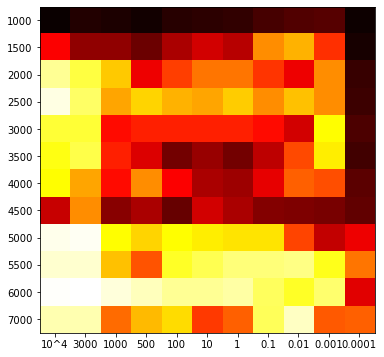

In [69]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   

fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[0] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [70]:
maxtuple = np.where(resarray == np.amax(resarray))
print(featureoptions[maxtuple[0][0]], c_options[maxtuple[1][0]])

6000 3000


In [40]:
grouper = GroupKFold(n_splits = 10)

docfreqs = []
for col in clean_wordcounts.columns:
    docfreqs.append((sum(clean_wordcounts[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-2000: ]] #because sorted ascending

train_features = cleantrain_freqs.loc[ : , features]  
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = .001, max_iter = 2000)
cleantrain_probabilities = cross_val_predict(bestmodel, train_features, cleantrain['simplegenre'], 
                                     groups = cleantrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = .001, max_iter = 2000)
bestmodel.fit(train_features, cleantrain['simplegenre'])

test_features = cleantest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

cleantest_predictions = bestmodel.predict(test_features)
cleantest_probabilities = bestmodel.predict_proba(test_features)

In [41]:
sum(cleantest_predictions == cleantest['simplegenre']) / len(cleantest['simplegenre'])

#quite accurate on the clean texts! 

0.9308176100628931

In [77]:
#Dirty model time 

resultarray = []

featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]
c_options = [100000, 10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

for featurecount in featureoptions:
    docfreqs = []
    for col in dirtytrain_freqs.columns:
        docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending
    
    model_features = dirtytrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fs', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features, 
                                    y = dirtytrain['simplegenre'], 
                                    groups = dirtytrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)

1000 100000 0.8363792118789263
1000 10000 0.8402912621359222
1000 3000 0.8393108699790597
1000 1000 0.8402912621359224
1000 500 0.8412716542927852
1000 100 0.8422520464496477
1000 10 0.8442128307633732
1000 1 0.8471444888635066
1000 0.1 0.853017323434228
1000 0.01 0.8579097658480869
1000 0.001 0.8657529031029888
1000 0.0001 0.8491052731772321
1500 100000 0.8637826004188083
1500 10000 0.8667237768893965
1500 3000 0.8677041690462592
1500 1000 0.872606129830573
1500 500 0.8735865219874357
1500 100 0.8755473063011612
1500 10 0.8765276984580239
1500 1 0.8735865219874357
1500 0.1 0.8735865219874357
1500 0.01 0.8765276984580239
1500 0.001 0.8784884827717494
1500 0.0001 0.8520559680182753
2000 100000 0.8775176089853417
2000 10000 0.8784884827717494
2000 3000 0.8784884827717496
2000 1000 0.8794688749286121
2000 500 0.8794688749286121
2000 100 0.8794688749286121
2000 10 0.8784884827717494
2000 1 0.8775080906148867
2000 0.1 0.8784884827717494
2000 0.01 0.8824100513992004
2000 0.001 0.877489053873

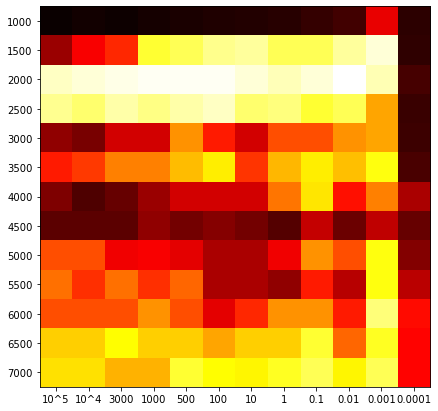

In [78]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   # I'm doing this because otherwise
                                                    # fine details at top of range can be hard to see.
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[0] = '10^5'
thexlabels[1] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [79]:
maxtuple = np.where(resarray == np.amax(resarray))
print(featureoptions[maxtuple[0][0]], c_options[maxtuple[1][0]])

2000 0.01


In [42]:
docfreqs = []
for col in dirtytrain_freqs.columns:
    docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-2000 : ]]

train_features = dirtytrain_freqs.loc[ : , features]
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = .01, max_iter = 2000)
dirtytrain_probabilities = cross_val_predict(bestmodel, train_features, dirtytrain['simplegenre'], 
                                     groups = dirtytrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = .01, max_iter = 2000)
bestmodel.fit(train_features, dirtytrain['simplegenre'])

test_features = dirtytest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features)    # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

dirtytest_predictions = bestmodel.predict(test_features)
dirtytest_probabilities = bestmodel.predict_proba(test_features)

In [43]:

sum(dirtytest_predictions == dirtytest['simplegenre']) / len(dirtytest['simplegenre'])

0.9159159159159159

In [53]:
#dirty-texts model is a bit less accurate (92 v 89)

In [44]:
#Why is it less accurate to model on Hathi texts? 

# Predicted vs real "distance" (directonal or absolute)

dirty_y = dirtymodelmeta['simplegenre'].map({'bio': 1, 'fic': 0})  # we already put this in train-test order
                                                            # so it will match the next line
dirty_probabilities = np.append(dirtytrain_probabilities[ : , 0], dirtytest_probabilities[ : , 0])

In [45]:
dirty_error = dirty_y - dirty_probabilities
dirty_absolute_error = np.abs(dirty_error)

In [46]:
clean_y = cleanmodelmeta['simplegenre'].map({'bio': 1, 'fic': 0})

clean_probabilities = np.append(cleantrain_probabilities[ : , 0], cleantest_probabilities[ : , 0])

In [47]:
clean_error = clean_y - clean_probabilities
clean_absolute_error = np.abs(clean_error)

In [48]:
#Create dataframe of average error for vols as a whole (avg the chunks)
clean_gbi = [get_gbindex(x) for x in cleanmodelmeta['chunkid']]
clean_df = pd.DataFrame({'chunkid': cleanmodelmeta['chunkid'], 'gbindex': clean_gbi,
                         'clean_error': clean_error, 'clean_abs_error': clean_absolute_error})

In [49]:
meandf = clean_df.groupby('gbindex').mean()
meandf.sample(10)

,clean_error,clean_abs_error
gbindex,,
40919,0.232118,0.232118
468,-0.247688,0.247688
40385,-0.056425,0.056425
41324,0.554383,0.554383
42281,0.102313,0.102313
40205,0.226957,0.226957
28380,0.023274,0.023274
52599,-0.149591,0.149591
37820,-0.265469,0.265469


In [50]:
dirty_gbi = [get_gbindex(x) for x in dirtymodelmeta['chunkid']]
dirty_df = pd.DataFrame({'chunkid': list(dirtymodelmeta['chunkid']), 'gbindex': dirty_gbi,
                         'dirty_error': dirty_error, 'dirty_abs_error': dirty_absolute_error})

In [51]:
dirty_df.sample(5)

,chunkid,gbindex,dirty_error,dirty_abs_error
1001,652_2,652,-0.152706,0.152706
1400,LennCFQ2fic_3,LennCFQ2fic,-0.001295,0.001295
1025,7777_6,7777,0.067836,0.067836
271,33573_0,33573,-0.140319,0.140319
753,46651_0,46651,0.044950,0.044950


In [52]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex')
dirty_df['error_divergence'] = dirty_df['dirty_error'] - dirty_df['clean_error']
dirty_df['divergence_of_abs_error'] = dirty_df['dirty_abs_error'] - dirty_df['clean_abs_error']
dirty_df.sample(10)

,chunkid,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
378,36534_4,36534,0.063752,0.063752,0.342333,0.342333,-0.278580,-0.278580
1420,WartTLSbio_2,WartTLSbio,0.010887,0.010887,0.046287,0.046287,-0.035401,-0.035401
392,36928_5,36928,0.010079,0.010079,0.105049,0.105049,-0.094970,-0.094970
610,41636_9,41636,-0.038097,0.038097,-0.086390,0.086390,0.048292,-0.048292
1316,51932_5,51932,0.216864,0.216864,0.430285,0.430285,-0.213421,-0.213421
1269,42857_1,42857,0.153012,0.153012,0.319066,0.319066,-0.166055,-0.166055
1265,41420_2,41420,-0.036461,0.036461,-0.173601,0.173601,0.137140,-0.137140
276,33573_5,33573,-0.039807,0.039807,-0.166749,0.166749,0.126942,-0.126942
1263,41420_0,41420,-0.051208,0.051208,-0.173601,0.173601,0.122393,-0.122393
1293,47209_5,47209,0.073598,0.073598,0.178967,0.178967,-0.105368,-0.105368


In [53]:
error0 = pd.read_csv('chunkmismatch/hathinocorrerrs0.tsv', sep = '\t')
error1 = pd.read_csv('chunkmismatch/hathinocorrerrs1.tsv', sep = '\t')
error2 = pd.read_csv('chunkmismatch/hathinocorrerrs2.tsv', sep = '\t')
error3 = pd.read_csv('chunkmismatch/hathinocorrerrs3.tsv', sep = '\t')
error4 = pd.read_csv('chunkmismatch/hathinocorrerrs4.tsv', sep = '\t')
#error5 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs5.tsv', sep = '\t')
chunkerrors = pd.concat([error0, error1, error2, error3, error4], ignore_index = True)

In [54]:
#Word error (OCR) or passage fail (paratext)? 

In [55]:
chunkerrors.columns

Index(['chunkid', 'passagefails', 'worderrors'], dtype='object')

In [56]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid', how = 'left')
chunkerrors.shape

(2624, 10)

In [57]:
chunkerrors.dropna(inplace=True)
chunkerrors.shape

(1426, 10)

In [58]:
pearsonr(chunkerrors['error_divergence'], chunkerrors['divergence_of_abs_error'])

(0.042103836405116835, 0.11200328149064077)

In [59]:
pearsonr(chunkerrors['passagefails'], chunkerrors['error_divergence'])

(-0.06695231271526778, 0.011442003504967421)

In [60]:
pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_error'])

(-0.03868083038226551, 0.14430463388372888)

In [61]:
pearsonr(chunkerrors['worderrors'], chunkerrors['error_divergence'])

(0.0904737345761333, 0.0006249980266686266)

In [62]:
pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_error']) #More OCR/word error than paratext 

(0.07183888858130313, 0.006648860489540979)

In [63]:
pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['error_divergence']))

(0.062333850462691805, 0.018567515156947167)

In [64]:
pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['error_divergence']))

(0.008311712922828434, 0.7538244584168414)

Here, it looks like paratext is positively correlated with less accurate results (higher div of absolute error) -- so like we expected, paratext differences or "passage fails" are our primary suspects for error when dealing with fic v bios. 

In terms of direction, I think both more OCR error and more paratext/passage fail makes the model more likely to predict that the chunk comes from a biography. 

In [65]:
pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors']) #Not a high correlation (less chance of collinearity)

(0.06986153838338349, 0.008313827760232189)

In [66]:
y = chunkerrors['divergence_of_abs_error']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_error   R-squared:                       0.007
Model:                                 OLS   Adj. R-squared:                  0.006
Method:                      Least Squares   F-statistic:                     5.073
Date:                     Thu, 01 Jul 2021   Prob (F-statistic):            0.00638
Time:                             07:53:55   Log-Likelihood:                 708.89
No. Observations:                     1426   AIC:                            -1412.
Df Residuals:                         1423   BIC:                            -1396.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [67]:
y = chunkerrors['error_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       error_divergence   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9.796
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           5.95e-05
Time:                        07:53:55   Log-Likelihood:                 638.46
No. Observations:                1426   AIC:                            -1271.
Df Residuals:                    1423   BIC:                            -1255.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0024      0.005     -0.469   

In [68]:
#Analysis -- What is it about these chunks that distorts the model?? 

In [69]:
chunkerrors.head()

,chunkid,passagefails,worderrors,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
4,49154_0,0.25348,0.00373,49154,0.891056,0.891056,0.31234,0.31234,0.578716,0.578716
5,49154_1,0.04947,0.00665,49154,0.461531,0.461531,0.31234,0.31234,0.149191,0.149191
6,49154_2,0.06392,0.00883,49154,0.067340,0.067340,0.31234,0.31234,-0.245001,-0.245001
7,49154_3,0.04655,0.00691,49154,0.390289,0.390289,0.31234,0.31234,0.077949,0.077949
8,49154_4,0.04689,0.01022,49154,0.166384,0.166384,0.31234,0.31234,-0.145957,-0.145957


In [71]:
topchunks = chunkerrors.sort_values('divergence_of_abs_error', ascending =False)

Chunks to inspect: 34240_9, 54218_1, 52603_8, 30236_4, PsalGMPbio_1 

In [73]:
topchunks[:10]

,chunkid,passagefails,worderrors,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
2125,34240_9,0.93627,0.00967,34240,-0.976945,0.976945,-0.207698,0.207698,-0.769246,0.769246
2283,54218_1,0.01243,0.00408,54218,0.954232,0.954232,0.192185,0.192185,0.762047,0.762047
126,52603_8,0.01213,0.01518,52603,-0.954148,0.954148,-0.275409,0.275409,-0.678739,0.678739
2181,30236_4,0.44603,0.01463,30236,-0.928959,0.928959,-0.277265,0.277265,-0.651694,0.651694
1401,PsalGMPbio_1,0.00524,0.15943,PsalGMPbio,0.842436,0.842436,0.190883,0.190883,0.651553,0.651553
204,40205_4,0.05963,0.02673,40205,0.865329,0.865329,0.226957,0.226957,0.638373,0.638373
2276,30749_4,0.01141,0.01638,30749,-0.889256,0.889256,-0.285175,0.285175,-0.604081,0.604081
2281,30749_9,0.16558,0.01466,30749,-0.863997,0.863997,-0.285175,0.285175,-0.578822,0.578822
4,49154_0,0.25348,0.00373,49154,0.891056,0.891056,0.312340,0.312340,0.578716,0.578716
664,57472_2,0.04499,0.01597,57472,0.904472,0.904472,0.338296,0.338296,0.566176,0.566176
